# Exploring the Drought in Kenya using Soil Moisture
<img src="media/Land_logo.png" alt="CCI Land banner" width="1000"/>

License: 
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>

# 1. Introduction to the exercise
Kenya is a drought-prone country, mainly due to its peculiar environmental conditions. While agriculture supports up to 75% of Kenya's population and generates almost all food requirements, drought is a major constraint on rain-fed agricultural production, particularly in arid and semi-arid Kenya. In the last century, Kenya has faced almost 29 droughts, some of them in the last decade. The frequency and severity of droughts in Kenya seems to be increasing over time. As a result, crop failures and livestock deaths are leading to severe food shortages in Kenya and food insecurity. [The Climate Change Initiative hosts a soil moisture dataset](https://esa-soilmoisture-cci.org/) that can be used to generate an index of draught severity called Drought Index. In this exercise, we apply the soil moisture data to generate this Drought Indicator for Kenya.

![workflow](media/SM_exercise_kenya.png)
The input data is daily images of soil moisture (SM, m3/m3) for Kenya and for a number of years (2000.01.01-2020.01.01).
There are several approaches to obtaining periods of droughts following information on soil moisture. In this xcercise, we follow the Soil Moisture Deficit Index to address drought in Kenya.

1. Download the daily SM images for the area of interest and for the period considered 
2. Extract the agricultural area using landcover map
3. Calculate the average SM per month
4. Group the monthly SM by month (all monthly SM of January, February, etc.) for the time span concerned
5. Calculate the median, maximum, and minimum values per pixel of the long term monthly images. Three images per month
6. With the actual image of the SM of a given month (SWj), calculate the monthly soil deficit of the month (SDj)
7. With (SDj) and the Soil Moisture Deficit Index of the month (j-1) (SMDIj-1), calculate the SMDIj. Note: SMDI1= SD1/50 for initial month
8. -4 <= SMDIj <= 4 indicating from very dry to very wet conditions
9. Identify the very dry areas by identifying a consecutive number of months of negative SMDIj.
10. Identify the year and the months of the very dry area in Kenya


## 1.1. Exercise objectives
In this exercise you will learn to use Cate in order to:
1. Search for soil moisture data from the [ESA CCI Open data portal](https://climate.esa.int/en/odp/#/dashboard)
2. Apply the soil moisture data to generate information required for the drought model
3. Create a drought index based on soil moisture dataset for Kenya
4. Identify periods and regions of drought over Kenya

## Getting started with jupyter notebooks and the cate webui
If you haven't done so please follow the [CATE from Jupyter notebooks](https://www.futurelearn.com/courses/understanding-climate-change-using-satellite-data/1/steps/1271881) to get started using the Jupyter notebook exercises.

## CATE software and the open data portal

We'll be querying the open data portal for soil moisture products as produced by the [Climate Change Initiative Soil Moisture project](https://climate.esa.int/en/projects/soil-moisture/). The [**open data portal**](https://climate.esa.int/en/odp/#/dashboard) hosts a variety of datasets on the [Jasmin infrastructure in the UK](https://jasmin.ac.uk/). These can be queried using the dedicated [CATE python module](https://cate.readthedocs.io/en/latest/). CATE allows retrieving data from the data portal using its [web-interface](https://cate.climate.esa.int).

In this Jupyter notebook exercise, we will directly call CATE functions, and it will show you how these can be used in advanced workflows.

## Starting the exercise
To perform the exercise and execute the code in this notebook you can run it through the [mybinder.org](https://mybinder.org/) service by clicking on the binder link below (if resources allow it). Alternatively, you can download/clone the notebooks from [github](https://github.com/CCI-Tools/cate-edu) and run them through your own Jupyter notebook instance (this may initially take more time to setup, but does allow you to store your changes and extend the notebooks exercises to your own needs).

[![click to run this notebook on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CCI-Tools/cate-edu/10eaadd3924621444631fe2ea0d3f51a224244ee?urlpath=lab%2Ftree%2FECVs%2FLand%2FExploring_drought_Kenya.ipynb)

or [clone the notebook repository on github](https://github.com/CCI-Tools/cate-edu)

## 1.2. Are you ready to go?
Please follow the steps below, and run all the code cells step by step
Here are a few technical reminders:
* `tabs` play an important role in python and remove the need for brackets. If you incorrectly align you code, it will not run and you'll get alignment errors.
* you can execute **code cells**, by selecting the cell and pressing either the *play* button or pressing `Ctrl+Enter`
* Indexing in python is 0-based (i.e. the first entry is denoted by 0)
* You're encouraged to try out different settings

## 1.3. Initializing some modules 

In [1]:
# Load some parts of the cate module so we can communicate with its datastore

from cate.core import DATA_STORE_POOL
import cate.ops as ops
from cate.ops.io import open_dataset

from datetime import datetime

from shapely import wkt # needed later when we apply regional constraints
import xarray as xr # Xarray allows flexible indexing of multi-dimensional arrays. Xarray Datasets and DataArrays underly many routines in cate
import numpy as np
import dask # allows some computations to be faster

import logging
# There are some irrelevant warnings later which we want to suppressed 
logging.captureWarnings(True) #although when developing code it's usually better to keep this disabled)

import warnings
warnings.filterwarnings('ignore')

# plotting tools
import matplotlib.pyplot as plt
import cartopy.crs as ccrs #to work with geographical projections

# When we plot, we would like the figures to appear in the notebook itself
%matplotlib inline 

# We need this temporary hack to work around (https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop)
#import nest_asyncio
#nest_asyncio.apply()

# the following is needed to run Cate in a Jupyter Notebook
from xcube.util.ipython import enable_asyncio
enable_asyncio()
    
import cartopy.feature as cfeature

To begin, let us see which data stores are available in the Data Store Pool.

In [2]:
DATA_STORE_POOL.store_instance_ids

['cci-store', 'cci-zarr-store', 'local']

In [3]:
# uncomment/comment the cci_store variable below to use the 
cci_store = 'cci-zarr-store'
# cci_store = 'cci-store'

data_store = DATA_STORE_POOL.get_store(cci_store)
display(data_store.get_search_params_schema())

# 2. Find the required data in ESA's CCI Open Data Portal

## 2.1. List all data in the CCI ZARR store

Let's start with finding 'Soil Moisture', and 'Land Cover' data by querying for the Essential Climate Variables name `SOILMOISTURE` and `LAND_COVER`



In [4]:
if cci_store == 'cci-zarr-store':
    #you can also list all the data ids of the smaller zarr catalogue
    print(*list(data_store.get_data_ids()),sep="\n") 
else:
    soilmoistureQuery = data_store.search_data(ecv="SOILMOISTURE")
    for i,soilItem in enumerate(soilmoistureQuery):
        print(f"\nDataset item {i}:\nds_id: {soilItem.data_id}")
        display(soilItem)

ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr
ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr
ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr
ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr
ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr
ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr
ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr
ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr
ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr
ESACCI-OC-L3S-IOP-MERGED-1M_MONTHLY_4km_GEO_PML_OCx_QAA-1997-2020-fv5.0.zarr
ESACCI-PERMAFROST-L4-ALT-MODISLST-AREA4_PP-1997-2018-fv02.0.zarr
ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-2010-2017-fv2.0.zarr
ESACCI-SEAICE-L4-SICONC-AMSR_50.0kmEASE2-NH-2002-2017-fv2.1.zarr
ESACCI-SEALEVEL-IND-MSLTR-MERGED-1993-2016-fv02.zarr
ESACCI-SEALEVEL-L4-MSLA-MERGED-1993-2015-fv02.zarr
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr


## 2.2. Select the correct data name

In [5]:
#note the appropriate dataset is called slightly different depending on the cci-store which is being used
if cci_store == "cci-zarr-store":
    SMdataset_id = "ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr"
    LCdataset_id = "ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr"
else:
    SMdataset_id = "esacci.SOILMOISTURE.day.L3S.SSMV.multi-sensor.multi-platform.COMBINED.v05-3.r1"
    LCdataset_id = "esacci.LC.L4.LCCS.Map.300m.p1y.v20.7b.r1"# check this name
    
#describe the dataset
soil_descriptor = data_store.describe_data(SMdataset_id)
display(soil_descriptor)

LC_descriptor = data_store.describe_data(LCdataset_id)
display(LC_descriptor)


# 3. Download (a subset of) the data and store it 'locally'
Up to now, we just queried the open data portal but did not actually download or process any data. In the following steps you will be extracting the required data by setting constraints in time and space to reduce the data download. The soil moisture data will aslo be sampled on monthly intervals before being stored locally






## 3.1. Apply a regional restriction based a polygon
Polygons, and other geometrical objects can be conveniently expressed in the [Well Known Text representation (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry). The polygon below `Polygon (( ...))`, was drawn using [QGIS](https://www.qgis.org/en/site/) and exported as WKT.
The points of the polygon are represented in latitude (Lat), longitude(Long) coordinates. Start from the most left point, going clockwise and close the polygon, i.e. the first point should also appear as the last point. In this example we have a polygon with five points, so WKT expression is:
<cod>
Polygon((Lat1, Long1, Lat2, Long2, Lat3, Long, Lat4, Long4, Lat5, Long5, *Lat1, Long1*))</cod>

This Polygon should be loaded in a [Shapely Polygon object](https://shapely.readthedocs.io/en/stable/manual.html?highlight=Polygon#Polygon) so CATE can work with.

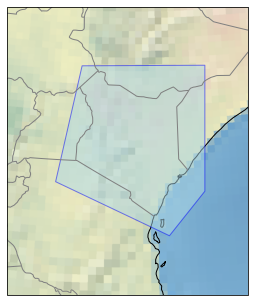

In [6]:
# The WKT representation representing the rough outline of the Kenya as a region of interest 

wktkenyaDrought = "Polygon ((34.0218774057365323 5.83180890691609211, 43.11430983816897111 5.80626836637555233, 42.62903956789870108 -3.10738028227309826, 40.17714767600680403 -5.96792082281363712, 32.5660665949257222 -2.494407309300124, 32.5660665949257222 -2.494407309300124, 32.5660665949257222 -2.494407309300124, 34.0218774057365323 5.83180890691609211))"
KenyaPoly = wkt.loads(wktkenyaDrought)

mapproj = ccrs.LambertConformal(central_longitude=37.9, central_latitude=-0.02)
# Curious as you might be, let's make a quick and dirty plot to see how the polygon looks like on a map
ax = plt.axes([0, 0, 1, 1], projection=mapproj)
ax.set_extent([30, 45, 10, -10])
ax.coastlines()
ax.stock_img()
ax.add_geometries([KenyaPoly], crs=ccrs.PlateCarree(), facecolor="lightblue", edgecolor="blue", alpha=0.5)

#spice up your plot with some Natural Earth country boundaries
ax.add_feature(cfeature.BORDERS, edgecolor='gray')


Results of step 3.1: Apply a polygon to the region of interest

## 3.2 Open a subset based upon region and time constraints

In [7]:
withinT = [datetime(2005,1,1),datetime(2020,12,31)]

# load the dataset
soilDset = open_dataset(ds_id=SMdataset_id, data_store_id=cci_store, time_range=withinT, normalize=True, region=wktkenyaDrought)



In [8]:
withinT1 = [datetime(2015,6,3),datetime(2015,7,3)]
# load the dataset
LCDset = open_dataset(ds_id=LCdataset_id, data_store_id=cci_store, time_range=withinT1, normalize=True, region=wktkenyaDrought)

## 3.3. Show that the correct dataset is opened

In [9]:
LCDset

<xarray.Dataset>
Dimensions:              (time: 1, lat: 4247, lon: 3797)
Coordinates:
  * lat                  (lat) float32 -5.965 -5.963 -5.96 ... 5.824 5.826 5.829
  * lon                  (lon) float32 32.57 32.57 32.57 ... 43.11 43.11 43.11
  * time                 (time) datetime64[ns] 2015-07-03
Data variables:
    change_count         (time, lat, lon) float32 dask.array<chunksize=(1, 852, 1236), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 dask.array<chunksize=(1, 852, 1236), meta=np.ndarray>
    lccs_class           (time, lat, lon) float32 dask.array<chunksize=(1, 852, 1236), meta=np.ndarray>
    observation_count    (time, lat, lon) float32 dask.array<chunksize=(1, 852, 1236), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 dask.array<chunksize=(1, 852, 1236), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2048:2048
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/b382ebe6679...
    cdm_data_type:              grid
    comment:                    
    contact:                    landcover-cci@uclouvain.be
    ...                         ...
    summary:                    This dataset contains the global ESA CCI land...
    time_coverage_end:          2015-07-03T00:00:00
    time_coverage_start:        2015-07-03T00:00:00
    title:                      ESA CCI Land Cover Map
    tracking_id:                12590bad-9014-4a91-9048-d06b67965490
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

# 4. Extract 'Agricultural Area' class from land cover map 

## 4.1. Extract soil moisture for the agricultural area. 
Use the agricultural area class to extract soil moisture for the agricultural area.
First, we need to create a mask based on the land cover class

0 no_data
10 cropland_rainfed
11 cropland_rainfed_herbaceous_cover
12 cropland_rainfed_tree_or_shrub_cover
20 cropland_irrigated
30 mosaic_cropland
40 mosaic_natural_vegetation
50 tree_broadleaved_evergreen_closed_to_open
60 tree_broadleaved_deciduous_closed_to_open
61 tree_broadleaved_deciduous_closed
62 tree_broadleaved_deciduous_open
70 tree_needleleaved_evergreen_closed_to_open
71 tree_needleleaved_evergreen_closed
72 tree_needleleaved_evergreen_open
80 tree_needleleaved_deciduous_closed_to_open
81 tree_needleleaved_deciduous_closed
82 tree_needleleaved_deciduous_open
90 tree_mixed
100 mosaic_tree_and_shrub
110 mosaic_herbaceous
120 shrubland
121 shrubland_evergreen
122 shrubland_deciduous
-126 grassland
-116 lichens_and_mosses
-106 sparse_vegetation
-105 sparse_tree
-104 sparse_shrub
-103 sparse_herbaceous
-96 tree_cover_flooded_fresh_or_brakish_water
-86 tree_cover_flooded_saline_water
-76 shrub_or_herbaceous_cover_flooded
-66 urban
-56 bare_areas
-55 bare_areas_consolidated
-54 

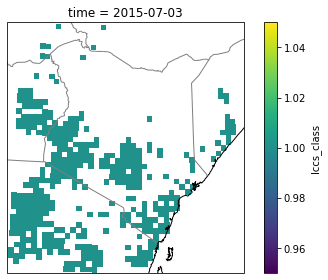

In [10]:
# print the land cover attributes (note: we need to split nameing at whitespace) and search for
for val,flag in zip(LCDset.lccs_class.attrs["flag_values"],LCDset.lccs_class.attrs["flag_meanings"].split()):
     print(val,flag)

#Let's make a list of the classes we're interested
import re
# in this case let's gather all classes which have 'crop' in it's name
agriclasses = [val for val,flag in zip(LCDset.lccs_class.attrs["flag_values"], LCDset.lccs_class.attrs["flag_meanings"].split()) if re.search('cropland',flag)]

# create  a mask and remove the time axis (it has only one coordinate)
mask = LCDset.lccs_class.isin(agriclasses).squeeze('time')

#interpolate mask onto the soil moisture grid so it can be more easily applied
masksm = mask.astype(int).interp(lat=soilDset.lat, lon=soilDset.lon, method='nearest')
masksm = masksm.where(masksm == 1) # set the 0 values to Nan (not a numbers)


# you can make a plot of the mask if you're interested
p = masksm.plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": mapproj})
p.axes.coastlines()
p.axes.add_feature(cfeature.BORDERS, edgecolor='gray')


Result step 4.2: Land cover classes in the area of interest

## 4.2. Monthly aggregate

In [11]:
smMonDset = ops.temporal_aggregation(ds=soilDset,method="mean",period="MS")


# 5. Soil Moisture Deficit Index (SMDI)

## 5.1. How to compute SMDI?


For soil moisture the method we will use is called the Soil moisture deficit index (SMDI). It is an index where the soil moisture of previous months are used to calculate the SMDI of the actual month.

Variables
1. ${SMDI}_j$= soil moisture deficit index of the month j
2. ${SMDI}_{j-1}$= SMDI at month j-1 (previous month) 
3. $SD_j$ = monthly soil deficit at month j  
4. $SW_j$ = actual monthly soil moisture at month j.The is the soil moiture map corresponding to a certain map
5. $MSW_j$= long-term monthly **median** available soil water at month j. There will be 12 maps, one per month.
6. $maxSW_j$= long-term monthly **maximum** available soil water at month j. There will be 12 maps, one per month.
7. $minSW_j$ = long-term monthly **minimum** available soil water at month j. There will be 12 maps, one per month.
8. NOTE: $_{j-1}$ stands for the month previous to month j.

**The sequence of the equations are**:
1. Calculate: $MSW_j$, $maxSW_j$, $minSW_j$
2. Calculate the monthly soil deficit for the month j
$$SD_j = (SW_j – MSW_j)/(maxSW_j – SW_j) *100,\quad  if SWj > MSWj$$ 
$$SD_j= (SW_j – MSW_j)/(MSW_j – minSW_j)* 100,\quad  if SW_j =< MSW_j$$ 
3. Calculate the soil moisture deficit index dor the month 1 (estimated and initial value)
$SMDI_1 = SD_1/50$  for initial month 
4. Calculate the soil moistiure deficit index for all the other months
$${SMDI}_j= 0.5 * {SMDI}_{j-1}+SD_j/50$$

The $SMDI_j$ value varies from -4 to 4 being the negatives indicators of drought. Persistant drought can be detected by monthly accumulation of negatives SMDI giving room to a number of analysis.

## 5.2. Compute the monthly climatology 

In [12]:
# get the median, min and max for all Jan's, Feb's etc.
smClim = soilDset.sm.groupby("time.month")
smMed, smMin, smMax = dask.compute(smClim.median(), smClim.min(), smClim.max())
# in case you don't want to use dask, uncomment the following, takes much longer, though
#smMed=smClim.median()
#smMin=smClim.min()
#smMax=smClim.max()


## 5.3. Compute SMDI

The cell below takes about 4 to 5 min when using dask in the cell above. 

In [13]:
# allocate enough data to hold the result (create an xarray.DataArray, and copy the coordinate axes lon,lat,time from the orginal dataset)

#Allocate the Soil Moisture deficit index

smdIndex = xr.DataArray(np.zeros(smMonDset.sm.shape), name="smd_indx", dims=["time","lat","lon"], coords={"lon":smMonDset.lon, "lat":smMonDset.lat, "time":smMonDset.time})

start_run_time = datetime.now()
for i,dt in enumerate(smMonDset.time.to_pandas()):
    #Monthly anomaly w.r.t. long term climatological median
    print(f"Compute Soil moisture deficit for {i}, {str(dt)}", end='\r')
    dSm = smMonDset.sm[i,:,:] - smMed[dt.month-1,:,:]
    smMed_m_min = smMed[dt.month-1,:,:] - smMin[dt.month-1,:,:]
    smMax_m_med = smMax[dt.month-1,:,:] - smMed[dt.month-1,:,:]
    smd = 100*xr.where(dSm < 0, dSm/smMed_m_min, dSm/smMax_m_med)
    
    #also mask results in the pixels of interest only
    smd = masksm*smd
    if i == 0:
        smdIndex[i,:,:] = smd/50
    else:
        smdIndex[i,:,:] = 0.5*smdIndex[i-1,:,:]+smd/50
print(f'\nTook {datetime.now() - start_run_time}')

Compute Soil moisture deficit for 191, 2020-12-01 00:00:00
Took 0:04:24.495921


# 6. Results analysis


Create a profile plot (for a location) and a map at a specific time

# 6.1. Create a simple time series plot of a location

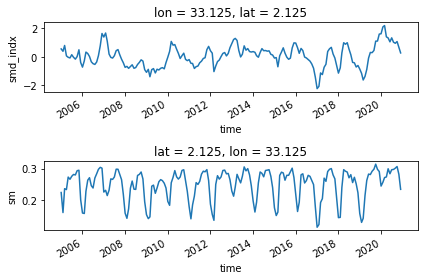

In [14]:
#plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=1)
ilon = 33
ilat = 2.0
ploc1 = smdIndex.sel(lat=ilat, lon=ilon, method="nearest").plot(ax=axes[0])
ploc2 = smMonDset.sm.sel(lat=ilat, lon=ilon, method="nearest").plot(ax=axes[1])

## Create a geographical plot at a certain month

Plotting epoch 2005-02-01T00:00:00.000000000


Text(0.5, 1.0, 'Soil moisture deficit index at 2005-02-01')

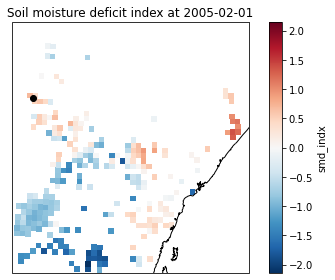

In [15]:
# Create a geographical plot at a certain month
it = 1
epoch = smdIndex.time[it].data
print(f"Plotting epoch {str(epoch)}")

ax = plt.subplot(projection=mapproj)
p = smdIndex.sel(time=epoch).plot(ax=ax, transform=ccrs.PlateCarree())

#also plot the location relevant for the plot above
ax.scatter([ilon], [ilat], transform=ccrs.PlateCarree(), color="black")
p.axes.coastlines()
p.axes.set_title(f"Soil moisture deficit index at {(str(epoch)[:10])}")


# 7. Questions
1. Try creating a time plot of the monthly mean of the SMDI
2. Identify the very dry areas by identifying a consecutive number of months of negative SMDIj.
3. Create a plot durng the drought period at certain key locations (e.g., Turkana, Mandera, Marsabit, Garissa, Wajir, Isiolo, Tana River, Machakos, Makueni, and Kitu)
3. Identify the year, and the months of the very dry area in Kenya.
4. Check out the 'https://foodsecurityindex.eiu.com/Country' and determoine the Global food security index for Kenya.
5. Check out the 'http://www.fao.org/publications/sofi/2020/en/' for Kenya and the interpret the number of undernourished people in that country.